# EEG Time Series Classification
### Classify if eyes of a human are open or shut with 14-Channel EEG Sensor Data

In [1]:
from scipy.io import arff
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split

In [2]:
data = arff.loadarff('./Data/EEG Eye State.arff')
df = pd.DataFrame(data[0])

In [3]:
df.eyeDetection.unique()

array([b'0', b'1'], dtype=object)

In [4]:
df['eyeDetection'] = df['eyeDetection'].apply(lambda x: 0 if b'0' in x else 1)

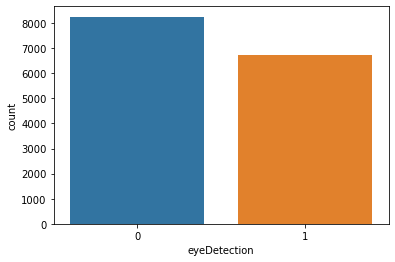

In [5]:
sns.countplot(data=df, x='eyeDetection')
plt.show()

In [6]:
df

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,4281.03,3990.26,4245.64,4116.92,4333.85,4614.36,4074.87,4625.64,4203.08,4221.54,4171.28,4269.23,4593.33,4340.51,1
14976,4276.92,3991.79,4245.13,4110.77,4332.82,4615.38,4073.33,4621.54,4194.36,4217.44,4162.56,4259.49,4590.26,4333.33,1
14977,4277.44,3990.77,4246.67,4113.85,4333.33,4615.38,4072.82,4623.59,4193.33,4212.82,4160.51,4257.95,4591.79,4339.49,1
14978,4284.62,3991.79,4251.28,4122.05,4334.36,4616.41,4080.51,4628.72,4200.00,4220.00,4165.64,4267.18,4596.41,4350.77,1


In [7]:
def plot_all_signals(save=False):
    for col in df.columns:
        a = df[col].values
        plt.figure(figsize=(18,2))
        plt.plot(a)
        if save:
            plt.savefig('./Plots/' + col + '.png')
        plt.show()

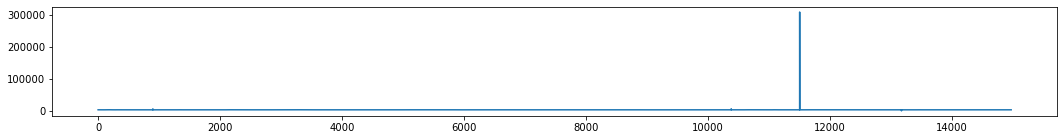

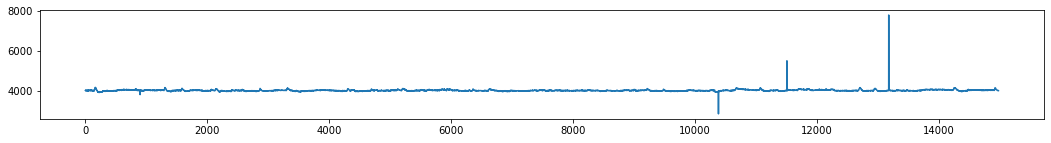

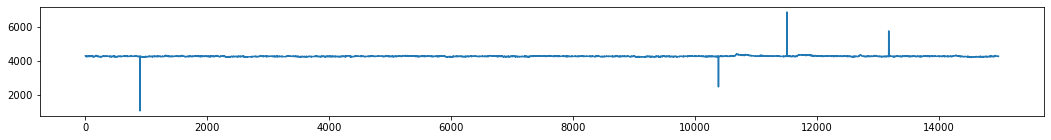

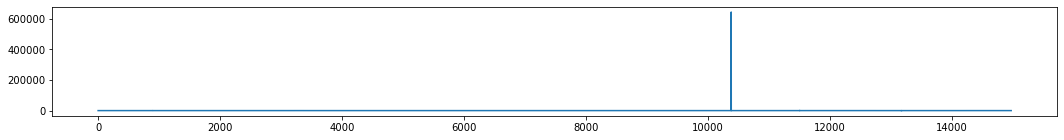

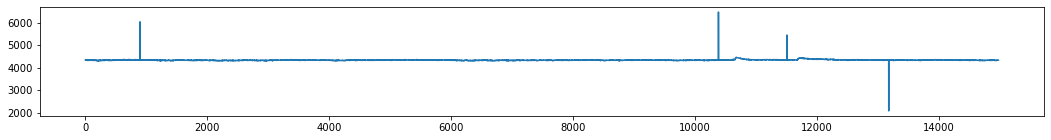

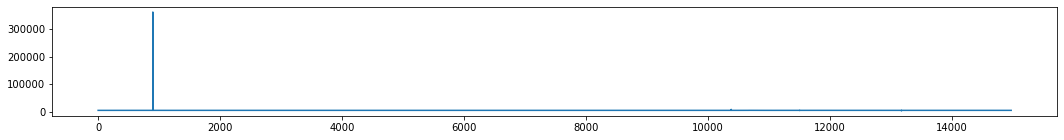

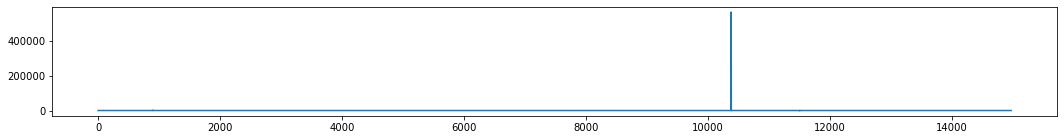

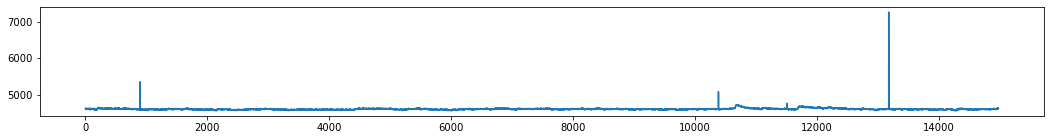

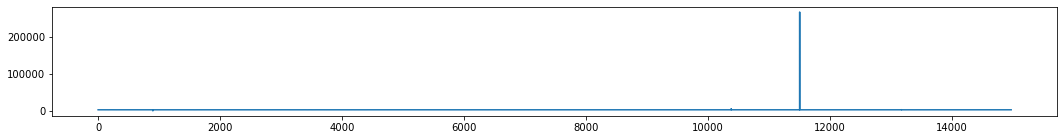

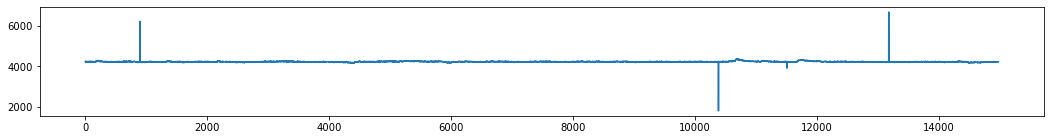

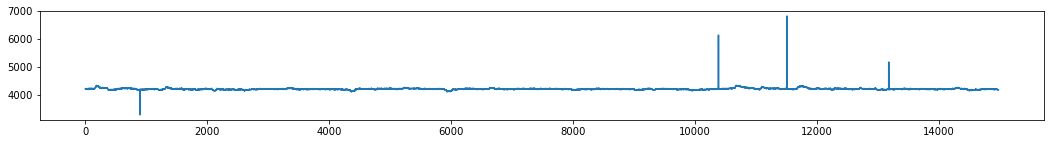

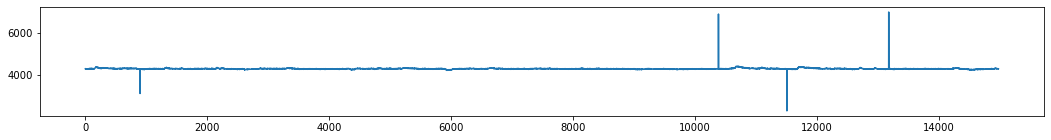

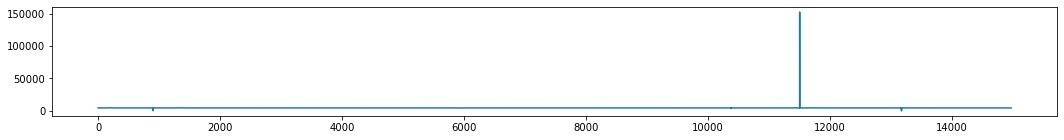

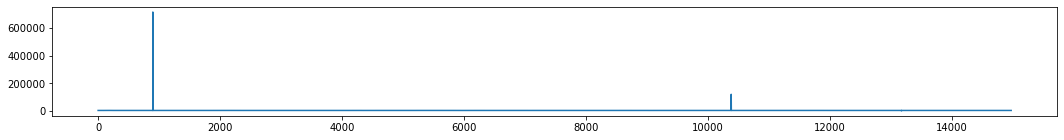

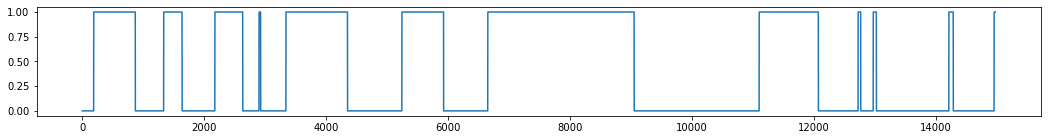

In [8]:
plot_all_signals()

#### Looks like we have Outlier in the Data!
Let´s remove them!

## Remove Outlier
We remove all outlier, that are 4 standard deviations under and above the mean!

In [9]:
def remove_outliers(dataframe, remove_above_std=4):
    '''Remove outlier that are 4 standard deviations away'''
    for col in dataframe.columns[:-1]:
        mean = np.mean(dataframe[col])
        std = np.std(dataframe[col])
        dataframe = dataframe[dataframe[col] > mean - remove_above_std*std]
        dataframe = dataframe[dataframe[col] < mean + remove_above_std*std]
    return dataframe
    
df = remove_outliers(df)
df2 = df.copy()

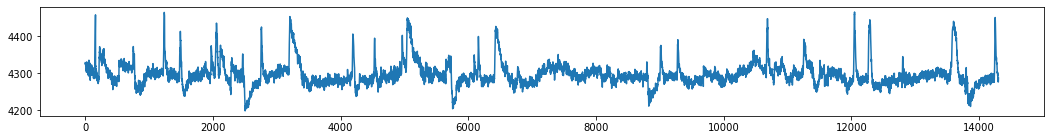

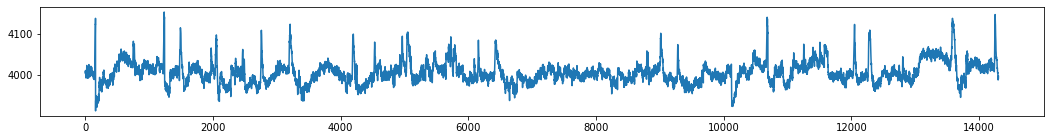

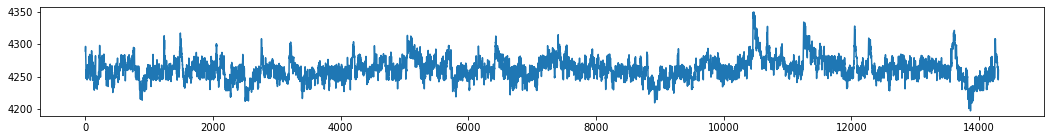

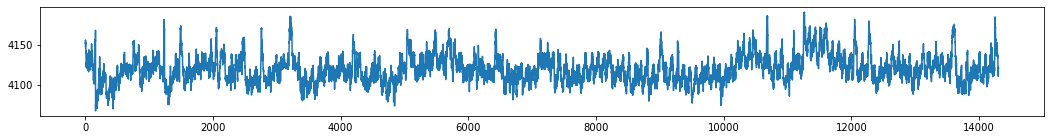

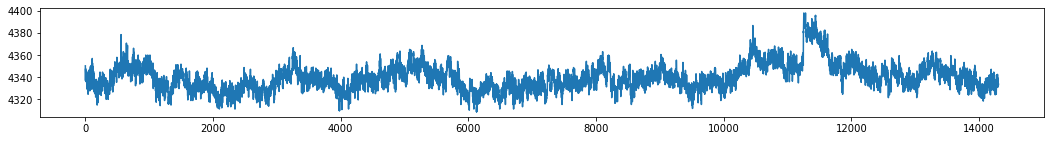

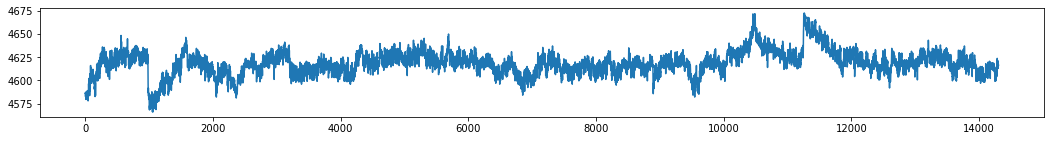

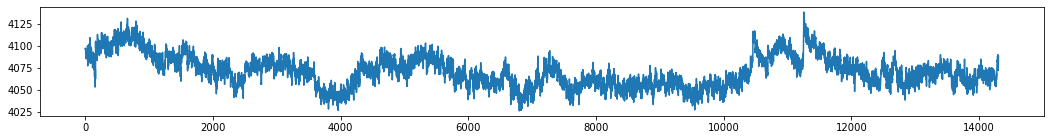

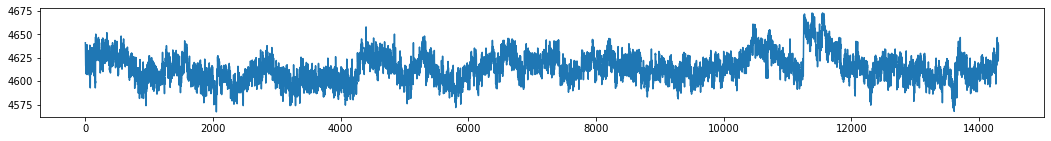

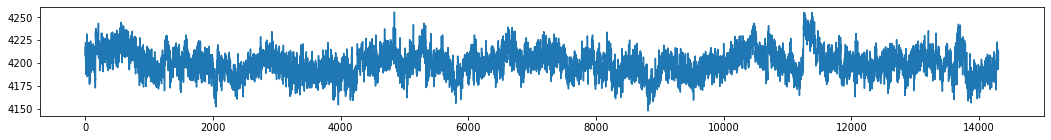

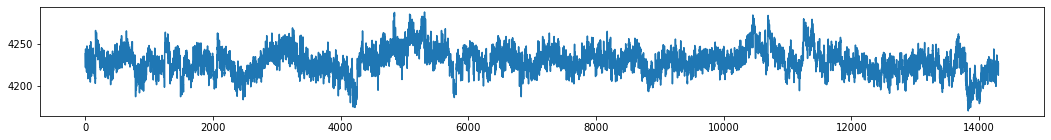

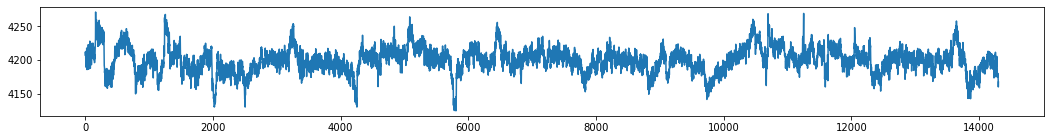

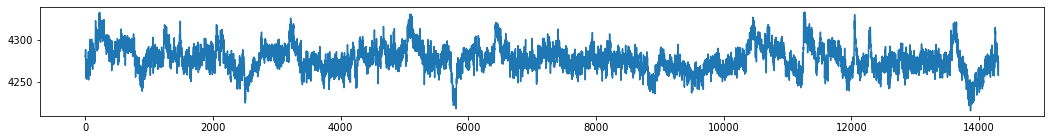

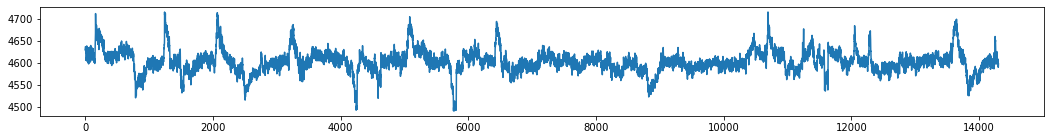

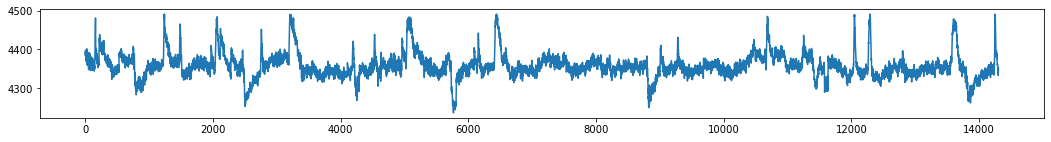

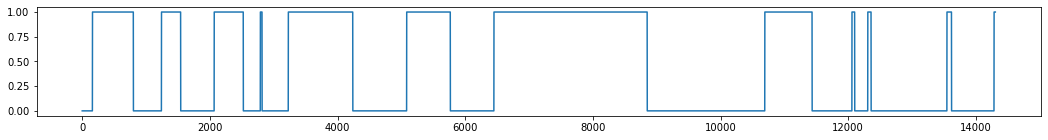

In [10]:
plot_all_signals(save=True)

Now the Data looks clean!
We can go on the modeling part now.

## Train Test Split & Scaling the data

In [11]:
y = df['eyeDetection'].values
y = tf.keras.utils.to_categorical(y)
X = df.drop('eyeDetection', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Dense Neural Network

In [13]:
class DenseModel(tf.keras.Model):
    def __init__(self, n_inputs):
        super().__init__()
        
        self.fc1 = Dense(200, activation='relu', input_shape=(n_inputs,))
        self.fc2 = Dense(80, activation='relu')
        self.out = Dense(2, activation='softmax')
    
    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.out(x)
        return x
    
model = DenseModel(n_inputs=X_train.shape[1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(X_train,
                    y_train,
                    shuffle=True,
                    epochs=40,
                    validation_data=(X_test, y_test))

Epoch 1/40
300/300 [==============================] - 0s 1ms/step - loss: 0.4806 - accuracy: 0.7785 - val_loss: 0.3611 - val_accuracy: 0.8477
Epoch 2/40
300/300 [==============================] - 0s 720us/step - loss: 0.3075 - accuracy: 0.8743 - val_loss: 0.2717 - val_accuracy: 0.8884
Epoch 3/40
300/300 [==============================] - 0s 719us/step - loss: 0.2438 - accuracy: 0.9025 - val_loss: 0.2324 - val_accuracy: 0.9024
Epoch 4/40
300/300 [==============================] - 0s 718us/step - loss: 0.2123 - accuracy: 0.9159 - val_loss: 0.2183 - val_accuracy: 0.9106
Epoch 5/40
300/300 [==============================] - 0s 740us/step - loss: 0.1785 - accuracy: 0.9303 - val_loss: 0.1850 - val_accuracy: 0.9269
Epoch 6/40
300/300 [==============================] - 0s 720us/step - loss: 0.1604 - accuracy: 0.9391 - val_loss: 0.1878 - val_accuracy: 0.9235
Epoch 7/40
300/300 [==============================] - 0s 723us/step - loss: 0.1411 - accuracy: 0.9456 - val_loss: 0.1613 - val_accuracy: 0

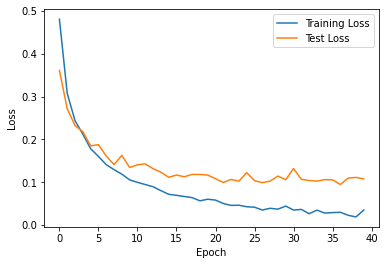

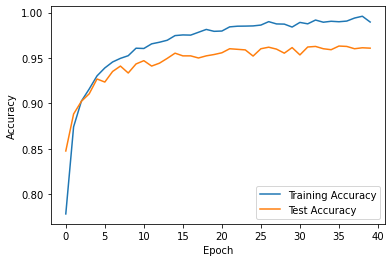

In [15]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./Plots/loss.png')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./Plots/acc.png')
plt.show()

In [16]:
pred_test = model.predict(X_test)

In [17]:
def plot_confusion_matrix(cm,
                          target_names,
                          title=' Confusion matrix',
                          cmap=None,
                          normalize=True,
                          dataset='_'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(dataset + title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('Plots/cm' + dataset + '.png')
    plt.show()

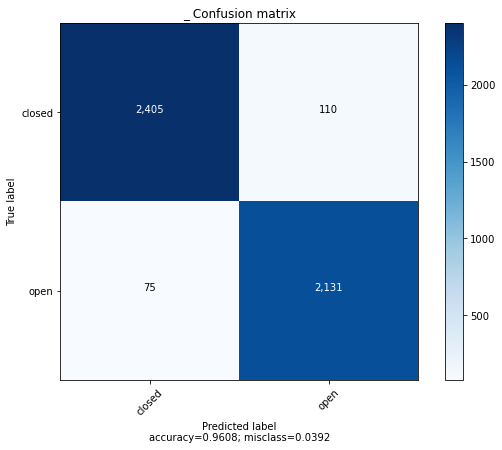

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(pred_test,axis=1), normalize=None)
plot_confusion_matrix(cm, ['closed', 'open'], normalize=False)

In [19]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score


print('Recall:', recall_score(np.argmax(y_test,axis=1), np.argmax(pred_test,axis=1)))
print('Precision:', precision_score(np.argmax(y_test,axis=1), np.argmax(pred_test,axis=1)))
print('Accuracy:', accuracy_score(np.argmax(y_test,axis=1), np.argmax(pred_test,axis=1)))

Recall: 0.9660018132366274
Precision: 0.9509147701918786
Accuracy: 0.9608133869942809


# Make better predictions!

## Make Rolling mean of signals!

In [20]:
ROLLING = 40

for col in df2.columns[:-1]:
    newcol = str(col) + '_mean'
    df2[newcol] = df2[str(col)].rolling(ROLLING, min_periods=1).mean()

Index(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4'],
      dtype='object')


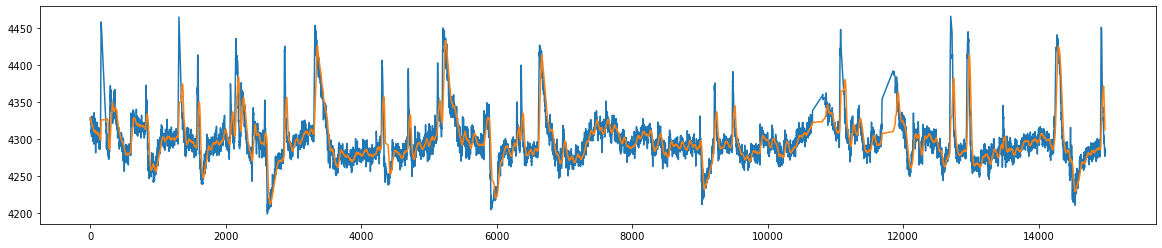

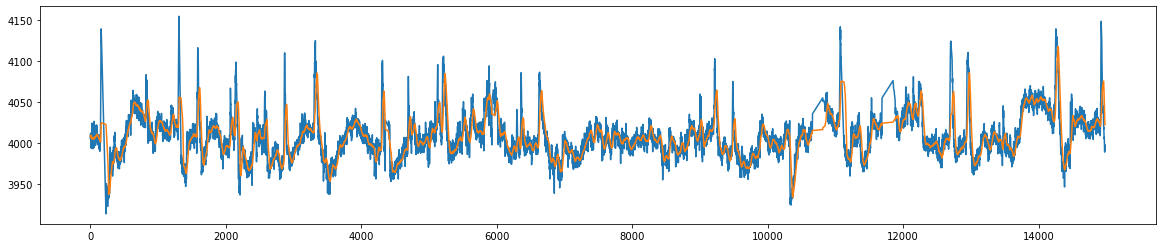

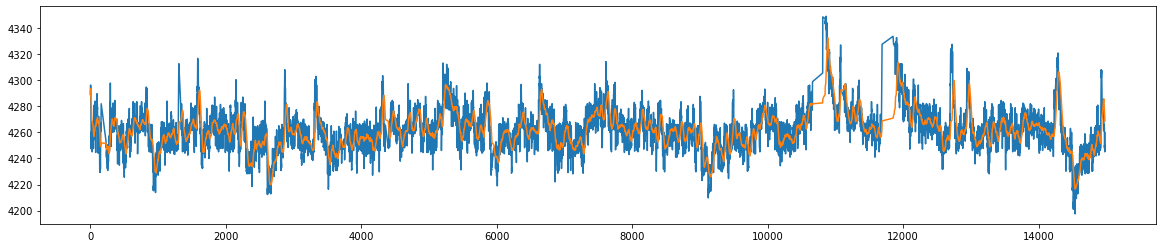

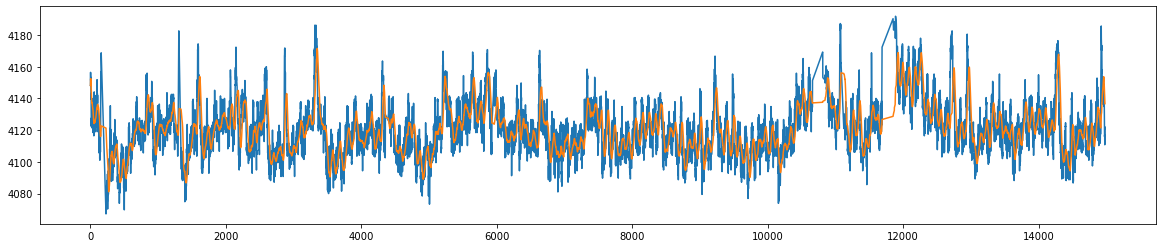

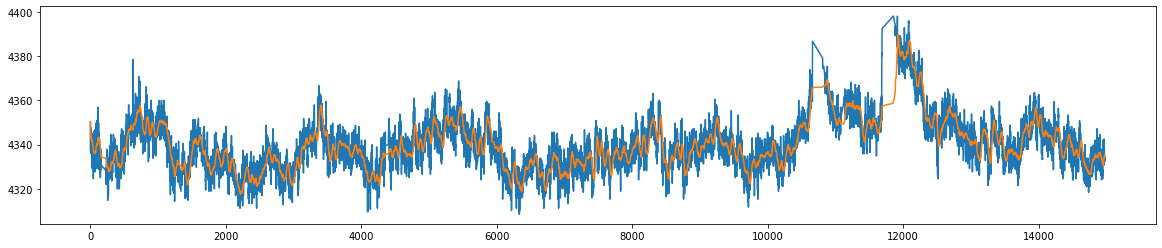

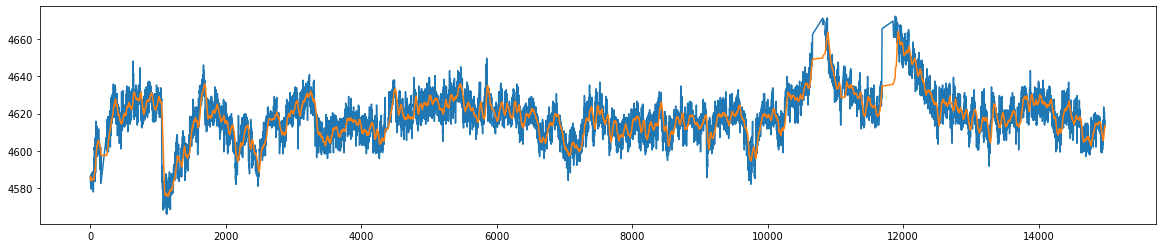

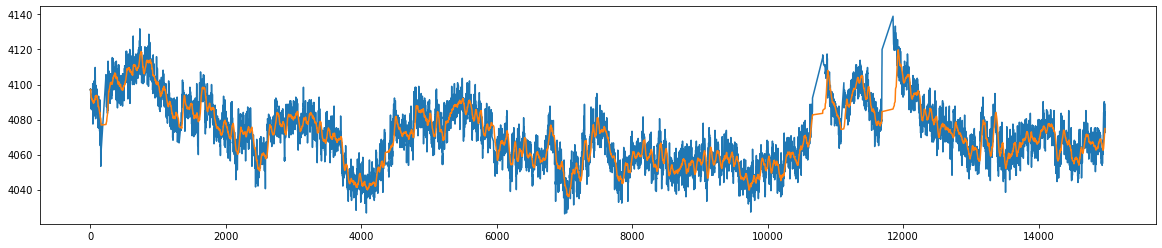

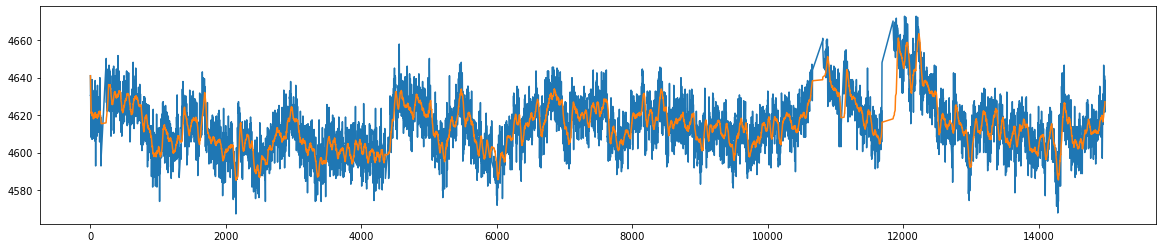

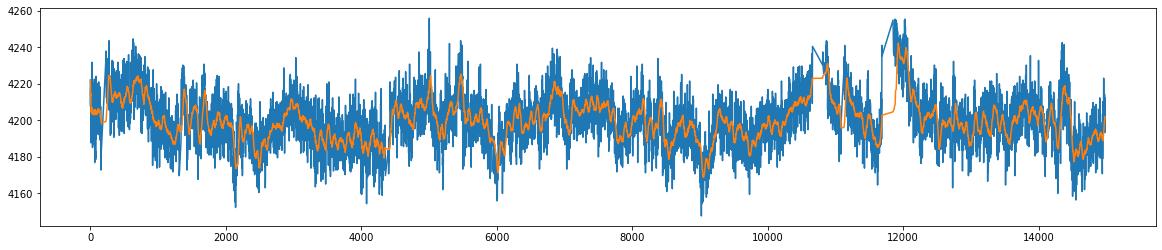

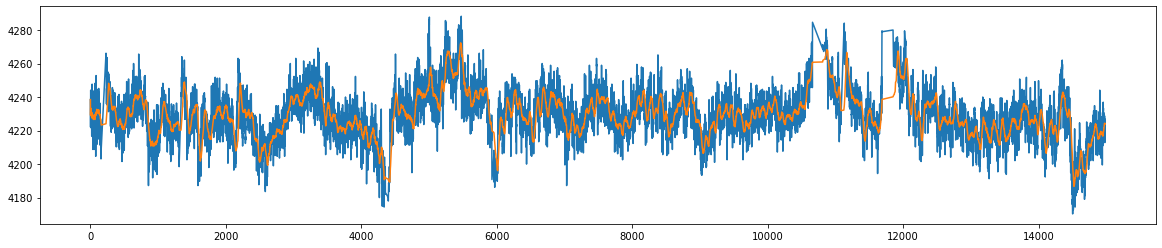

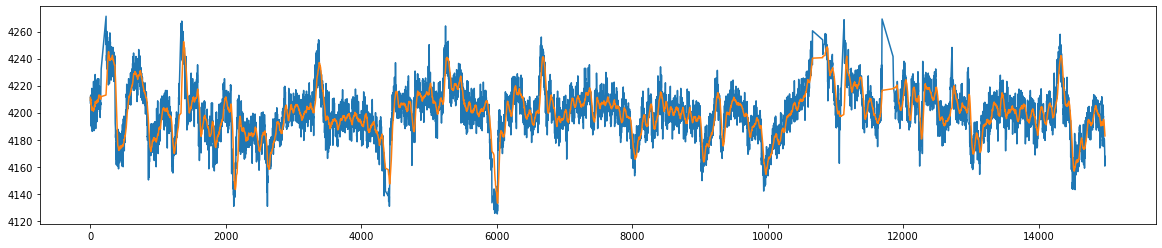

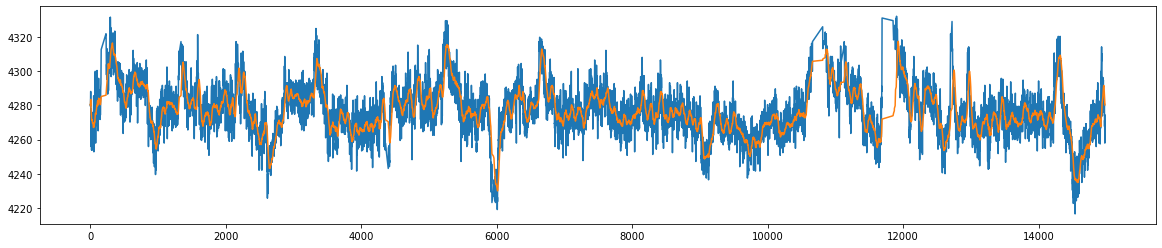

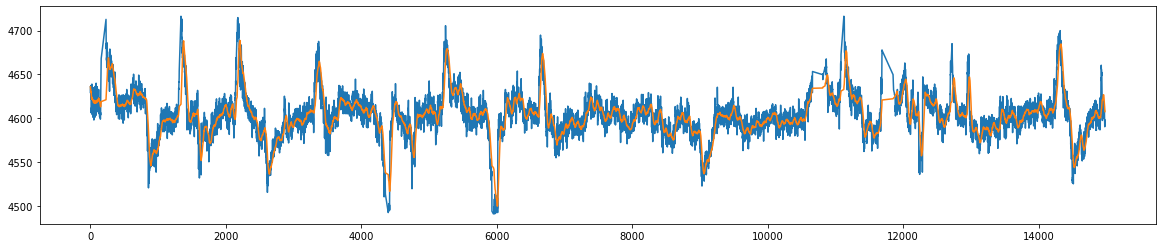

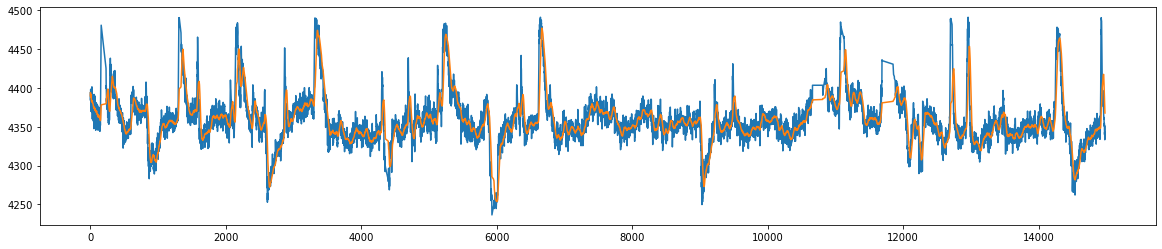

In [21]:
def plot_signals(dataframe):
    columns = dataframe.columns[:14]
    print(columns)
    for name in columns:
        plt.figure(figsize=(20, 4))
        dataframe[name].plot()
        dataframe[name + '_mean'].plot()
        plt.savefig('./Plots/' + name + '_mean' + '.png')
        plt.show()
        
plot_signals(df2)

## Correlation Matrix

<AxesSubplot:>

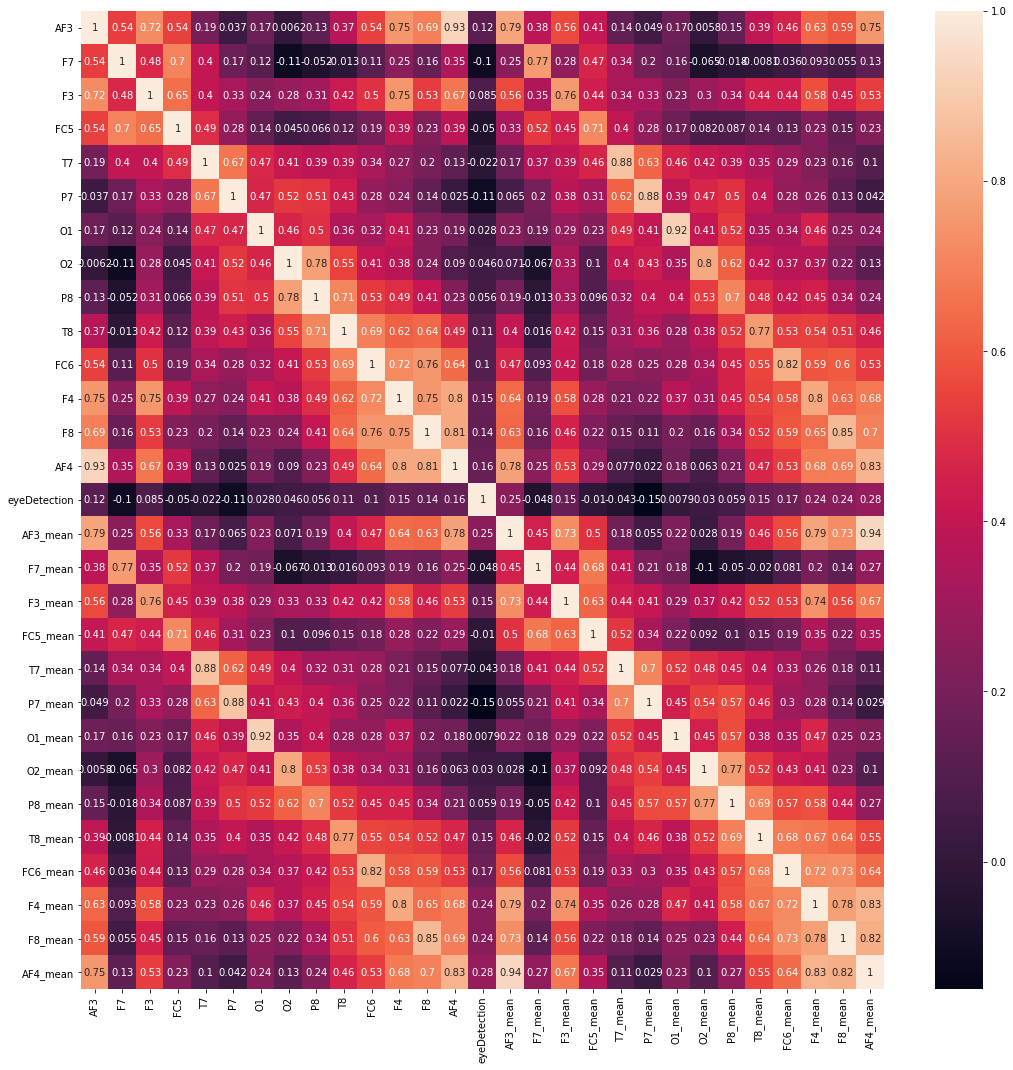

In [22]:
plt.figure(figsize=(18, 18))
sns.heatmap(df2.corr(), annot=True)

In [23]:
df2.columns

Index(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4', 'eyeDetection', 'AF3_mean', 'F7_mean', 'F3_mean',
       'FC5_mean', 'T7_mean', 'P7_mean', 'O1_mean', 'O2_mean', 'P8_mean',
       'T8_mean', 'FC6_mean', 'F4_mean', 'F8_mean', 'AF4_mean'],
      dtype='object')

## Drop all columns that have small correlation

In [24]:
corr = df2.corr()
corr = corr['eyeDetection']
drop = corr[abs(corr) < 0.08]
dropnames = list(drop.index)

df2.drop(dropnames, axis=1, inplace=True)

In [25]:
df2.columns

Index(['AF3', 'F7', 'F3', 'P7', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'eyeDetection',
       'AF3_mean', 'F3_mean', 'P7_mean', 'T8_mean', 'FC6_mean', 'F4_mean',
       'F8_mean', 'AF4_mean'],
      dtype='object')

<AxesSubplot:>

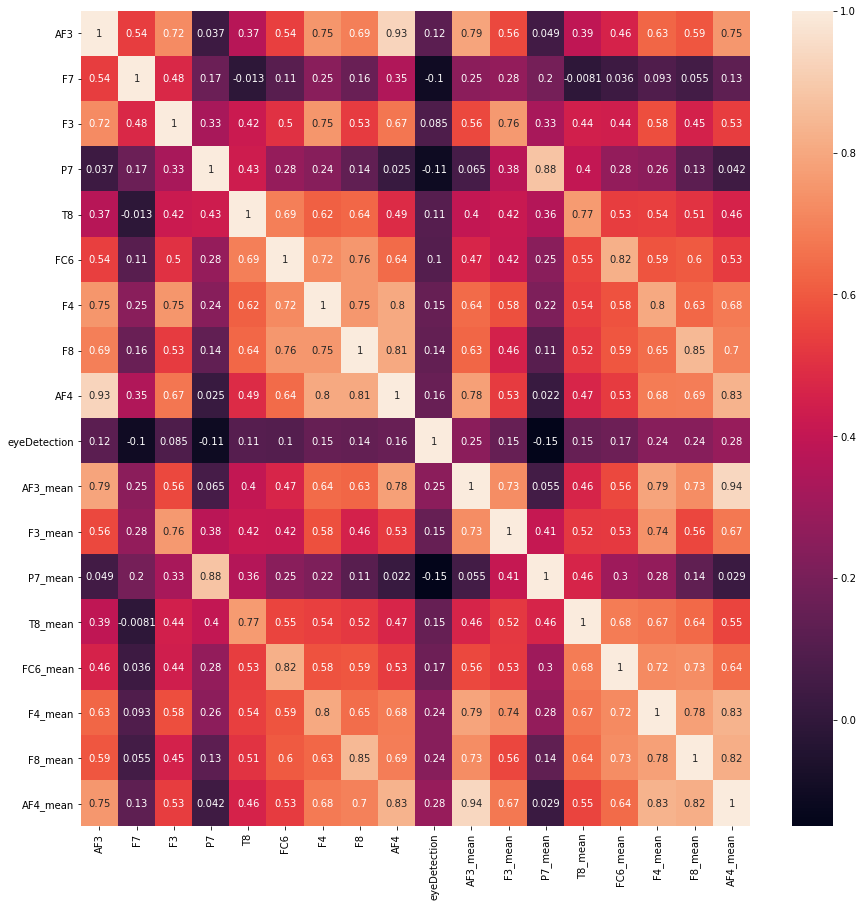

In [26]:
plt.figure(figsize=(15, 15))
sns.heatmap(df2.corr(), annot=True)

In [27]:
y = df2['eyeDetection'].values
y = tf.keras.utils.to_categorical(y)
X = df2.drop('eyeDetection', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

In [28]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
model = DenseModel(n_inputs=X_train.shape[1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(
                                    monitor='val_accuracy',
                                    min_delta=0,
                                    patience=100,
                                    verbose=0,
                                    mode='auto',
                                    baseline=None,
                                    restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    shuffle=True,
                    epochs=800,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping_monitor],
                    verbose=0)

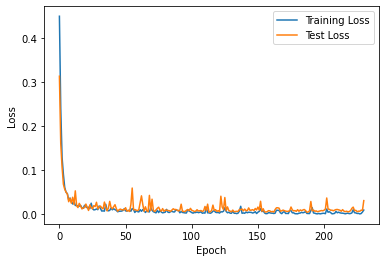

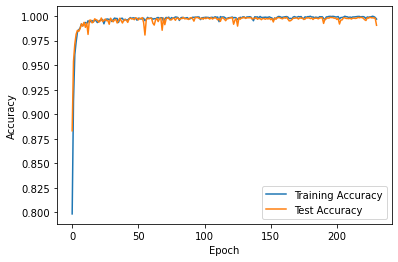

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./Plots/loss_BETTER.png')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./Plots/acc_BETTER.png')
plt.show()

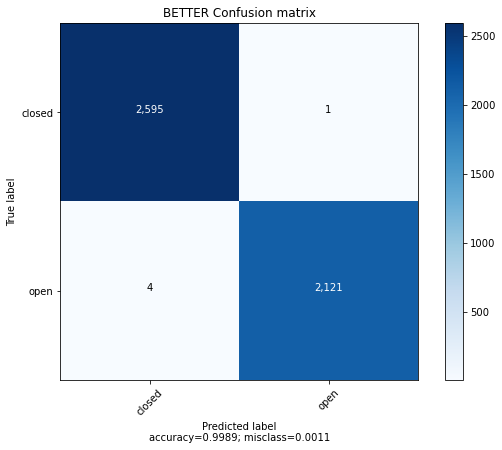

In [31]:
pred_test = model.predict(X_test)

cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(pred_test,axis=1), normalize=None)
plot_confusion_matrix(cm, ['closed', 'open'], normalize=False, dataset='BETTER')

In [32]:
print('Recall:', recall_score(np.argmax(y_test,axis=1), np.argmax(pred_test,axis=1)))
print('Precision:', precision_score(np.argmax(y_test,axis=1), np.argmax(pred_test,axis=1)))
print('Accuracy:', accuracy_score(np.argmax(y_test,axis=1), np.argmax(pred_test,axis=1)))

Recall: 0.9981176470588236
Precision: 0.9995287464655985
Accuracy: 0.9989409023511968
